# Importing the libraries

I'm importing pandas to handle data and numpy. The StratifiedKFold helps me split my data while keeping the same balance of classes, DecisionTreeClassifier works by asking yes/no questions SVC creates complex dividing lines and AdaBoost combines weaker models to make a stronger one.

To evaluate my models I'll use accuracy_score to see how often I'm right precision_score to check false alarms recall_score to find missed cases and f1_score for overall balance. The confusion_matrix shows where mistakes happen and classification_report gives a full performance summary.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings

Running the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RUNNING DATASET/Students_Grading_Dataset.csv')

In [ ]:
print(df.columns)

Index(['Student_ID', 'First_Name', 'Last_Name', 'Email', 'Gender', 'Age',
       'Department', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Grade', 'Study_Hours_per_Week',
       'Extracurricular_Activities', 'Internet_Access_at_Home',
       'Parent_Education_Level', 'Family_Income_Level', 'Stress_Level (1-10)',
       'Sleep_Hours_per_Night'],
      dtype='object')


In [ ]:
df.isnull().any()

,0
Student_ID,False
First_Name,False
Last_Name,False
Email,False
Gender,False
Age,False
Department,False
Attendance (%),False
Midterm_Score,False
Final_Score,False


I'm cleaning my student grades data by removing rows where the parent education level is missing. The dropna() function helps me do this. I'm only looking at the Parent_Education_Level column (that's what the subset part does). Any row that has empty or missing values in this column gets deleted from my dataframe.

In [ ]:
df = df.dropna(subset=['Parent_Education_Level'])

The code above checks if the dataset in student prediction have inconsistencies. Factors of this dataset can help us provide a quality prediction model. This is the first step of our Data Preprocessing.

In [ ]:
def check_outliers(usedcars, threshold=3):
    numeric_data = usedcars.select_dtypes(include=['number'])
    z_scores = np.abs((numeric_data - numeric_data.mean()) / numeric_data.std())
    outliers = (z_scores > threshold).sum()
    return outliers

# Check outliers
outliers = check_outliers(df)
print("\nOutliers per column before cleaning:")
print(outliers)


Outliers per column before cleaning:
Age                      0
Attendance (%)           0
Midterm_Score            0
Final_Score              0
Assignments_Avg          0
Quizzes_Avg              0
Participation_Score      0
Projects_Score           0
Total_Score              0
Study_Hours_per_Week     0
Stress_Level (1-10)      0
Sleep_Hours_per_Night    0
dtype: int64


a function called check_duplicate_values that looks for copies in my data. When I call this function and give it my dataframe df it counts how many rows are exact duplicates using df.duplicated().sum(). The function gives me back this count. Then I store the result in duplicate_values and print it out with a message saying "Number of Duplicate Value". This helps me know if I have identical rows in my data that might need to be removed. The backslash-n \n makes a blank line before printing to make the output look nicer. The colon : after the text separates my message from the actual number of duplicates found.

In [ ]:
#This code of function is use to check for duplicate values
def check_duplicate_values(df):
    duplicate_values = df.duplicated().sum()
    return duplicate_values

# Checking duplicate values
duplicate_values = check_duplicate_values(df)
print("\nNumber of Duplicate Value:", duplicate_values)


Number of Duplicate Value: 0


In [ ]:
null_values = df.isnull().sum()
duplicate_values = df.duplicated().sum()

print("Null Values per column: \n")

print(null_values)
print("")
print('Duplicate Values: ',duplicate_values)

Null Values per column: 

Student_ID                    0
First_Name                    0
Last_Name                     0
Email                         0
Gender                        0
Age                           0
Department                    0
Attendance (%)                0
Midterm_Score                 0
Final_Score                   0
Assignments_Avg               0
Quizzes_Avg                   0
Participation_Score           0
Projects_Score                0
Total_Score                   0
Grade                         0
Study_Hours_per_Week          0
Extracurricular_Activities    0
Internet_Access_at_Home       0
Parent_Education_Level        0
Family_Income_Level           0
Stress_Level (1-10)           0
Sleep_Hours_per_Night         0
dtype: int64

Duplicate Values:  0


I'm removing some columns from my student data that I don't need for my analysis. The columns_to_drop variable holds the names of columns I want to remove - Student_ID First_Name Last_Name and Email. These are personal details that aren't useful for looking at grades. The drop() function takes these columns out of my dataframe. I save the cleaned-up version back into df so now my data only has the important stuff left. This makes the data simpler to work with and protects student privacy too. The equals sign means I'm keeping the changed version of my data.

In [ ]:
columns_to_drop = ['Student_ID', 'First_Name', 'Last_Name', 'Email']
df = df.drop(columns=columns_to_drop)

I'm cleaning my data by removing weird values that are too far from normal. First I grab only the number columns from my data using select_dtypes. Then I calculate z-scores which tell me how far each value is from average. The np.abs makes all these scores positive so I only care about distance not direction.

In [ ]:
from scipy.stats import zscore

# Calculate z-scores only for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
z_scores = np.abs(zscore(numeric_cols))

# Keep only rows where all z-scores are less than 3
df = df[(z_scores < 3).all(axis=1)]


 check_overall_inconsistencies that looks for problems in my data. It goes through each column one by one checking for bad values like empty cells or missing data. When it finds something wrong it prints which column has the problem and what the bad values are. The function counts up all these problems and gives me back the total number. Then I print out how many issues were found with a nice message. This helps me spot dirty data that might need fixing before I do my analysis.

In [ ]:
# This Function is to check for inconsistencies in the overall dataset
def check_overall_inconsistencies(df):
    inconsistencies = 0

    # Iterate through each column
    for column in df.columns:
        # Check for any unexpected or invalid values
        unique_values = df[column].unique()
        invalid_values = [value for value in unique_values if pd.isna(value) or value == '']
        if invalid_values:
            print(f"Inconsistency found in column '{column}': Invalid values - {invalid_values}")
            inconsistencies += 1

    return inconsistencies

# Check inconsistencies in the overall dataset and then print the number of inconsistencies
overall_inconsistencies = check_overall_inconsistencies(df)
print("\nNumber of Overall Inconsistencies:", overall_inconsistencies)


Number of Overall Inconsistencies: 0


cleaning up my student data by removing rows where we don't know the parent's education level. The dropna() function helps me do this - it looks for missing values in just the Parent_Education_Level column (that's what the subset part does). Any row with empty or missing parent education info gets removed

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
df = df.dropna(subset=['Parent_Education_Level'])

getting my data ready for machine learning. First I split it into features (X) and labels (y). X has all the information about students except their grades while y contains just the grades. Since some data like categories need to be numbers for the computer I use get_dummies to convert them (drop_first removes extra columns we don't need). The grades are words like A B C so I use LabelEncoder to change them to numbers 0 1 2 etc. because the AdaBoost model needs numbers. Finally I set up StratifiedKFold which will split my data into 5 groups while keeping the same grade distribution in each group. The shuffle=True mixes the data first and random_state=42 makes sure I get the same splits every time I run this.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Define features (X) and label (y)
X = df.drop(columns=['Grade'])
y = df['Grade']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Encode labels (since AdaBoost requires numeric)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Setup Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


ignoring the warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

checking how many students got each grade in my data. First I count how many As Bs Cs etc. there are using value_counts() and print this out. Then I make a bar chart to see the grades visually. The plt.figure sets up the size of my chart. sns.countplot creates the bars showing how many students got each grade - I use the Set2 color palette to make it pretty. The plt.title and plt.xlabel/ylabel add clear labels so anyone can understand the chart. Finally plt.show() displays the graph. This helps me see if some grades are much more common than others which could affect my machine learning model later.

Class Distribution:
 Grade
D    824
B    805
F    796
A    794
C    756
Name: count, dtype: int64


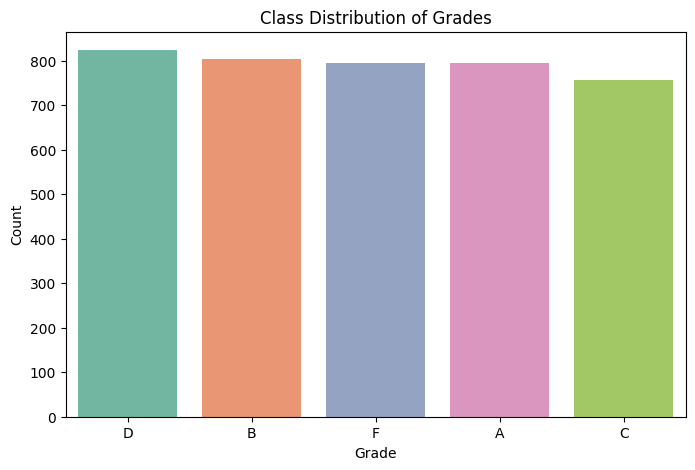

In [ ]:
# View class distribution
import matplotlib.pyplot as plt # Import the necessary module
import seaborn as sns

class_counts = df['Grade'].value_counts()
print("Class Distribution:\n", class_counts)

# Visualize imbalance
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Grade', order=class_counts.index, palette='Set2')
plt.title('Class Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

im setting up a logistic regression model to predict student grades. This model tries to find patterns in the data to classify students into different grade categories. I use solver='saga' because it works well with our kind of data. The max_iter=1000 tells the model to try up to 1000 times to find the best solution. Since we have multiple grade categories i set multi_class='multinomial' to handle this. The random_state=42 makes sure I get the same results if I run this again im just storing this setup in logreg_model so I can use it later to train and make predictions this is just preparing the model

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    solver='saga',
    max_iter=1000,
    multi_class='multinomial',
    random_state=42
)


I'm testing a special model that combines logistic regression with AdaBoost to predict student grades. First I set up k-fold validation which splits my data into 5 parts - I use 4 parts to train and 1 to test each time. This gives me more reliable results than just one test. For the model I use logistic regression as the base with some settings - max_iter=700 limits how long it tries to learn solver='saga' helps it work better and C=1 controls how strict it is. The AdaBoost part takes this model and makes 5 copies of it (n_estimators=5) that work together with a learning_rate=0.3 to improve predictions. After training I check how good it is using accuracy precision recall and F1 scores - these tell me different things about how many grades it predicts right. Finally I print the average scores across all 5 tests so I know how well it really works.


In [ ]:
#logistic regression
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #<-------------- kfold

# Initialize metric storage
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

# K-Fold Loop
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Initialize Logistic Regression base model for AdaBoost with optimizations
    base_lr = LogisticRegression(
        max_iter=700,             #<-------------- hyperparameter 2
       #solver='liblinear',
       #solver = 'newton-cg' ,
       #solver='lbfgs',             #<-------------- hyperparameter 3
       solver='saga',
        n_jobs=-1,
        C=1                  #<-------------- adjust this
    )


    # AdaBoost with Logistic Regression as the base estimator
    boosted_lr = AdaBoostClassifier(
        estimator=base_lr,
        n_estimators=5,            #<-------------- hyperparameter 1
        learning_rate=0.3,
        random_state=42
    )

    # Fit the AdaBoost model
    boosted_lr.fit(X_train, y_train)

    # Predict with the AdaBoost model
    y_pred_boosted_lr = boosted_lr.predict(X_test)

    # Metrics for the boosted model
    accuracy_list.append(accuracy_score(y_test, y_pred_boosted_lr))
    precision_list.append(precision_score(y_test, y_pred_boosted_lr, average='weighted', zero_division=0))
    recall_list.append(recall_score(y_test, y_pred_boosted_lr, average='weighted', zero_division=0))
    f1_list.append(f1_score(y_test, y_pred_boosted_lr, average='weighted', zero_division=0))

# Output average metrics
print("AdaBoost + Logistic Regression 5-Fold Results:")
print("Average Accuracy: {:.4f}".format(np.mean(accuracy_list)))
print("Average Precision: {:.4f}".format(np.mean(precision_list)))
print("Average Recall: {:.4f}".format(np.mean(recall_list)))
print("Average F1-score: {:.4f}".format(np.mean(f1_list)))

AdaBoost + Logistic Regression 5-Fold Results:
Average Accuracy: 0.2018
Average Precision: 0.2015
Average Recall: 0.2018
Average F1-score: 0.1884


making a decision tree model boosted with AdaBoost to predict student grades. First this is i create the base decision tree with some settings - max_depth=None lets it grow as big as needed criterion='entropy' helps it make better splits and min_samples_split=10 means it needs at least 10 students before making a new branch. Then I boost this tree with AdaBoost making 500 copies of it (n_estimators=500) that work together with learning_rate=1 to improve predictions. I train it on my data using fit() then test it with predict(). The accuracy tells me what percent it got right while precision recall and F1 give me more details about its mistakes. Finally I print both the settings I used and how well it performed so I can see if changing settings would help.

In [ ]:
# Base Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Base Decision Tree with manual hyperparameter setting
base_dt = DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_split=10, random_state=42)  #<-------------- hyperparameter tuning

# just paste this -----> criterion='entropy' or 'gini'

# AdaBoost hyperparameter
adaboost = AdaBoostClassifier(estimator=base_dt, n_estimators=500, learning_rate=1, random_state=42)

# Train (using the manually configured model)
adaboost.fit(X_train, y_train)

# Predictions using the trained model
y_pred = adaboost.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Output average metrics with hyperparameter values
print("AdaBoost + Decision Tree 5-Fold Results:")
print(f"Hyperparameter 1 (max_depth): {base_dt.max_depth}")
print(f"Hyperparameter 2 (criterion): {base_dt.criterion}")
print(f"Hyperparameter 3 (min_samples_split): {base_dt.min_samples_split}")
print("Average Accuracy: {:.4f}".format(accuracy))  # Print the accuracy directly
print("Average Precision: {:.4f}".format(precision))  # Print the precision directly
print("Average Recall: {:.4f}".format(recall))  # Print the recall directly
print("Average F1-score: {:.4f}".format(f1))  # Print the F1-score directly

AdaBoost + Decision Tree 5-Fold Results:
Hyperparameter 1 (max_depth): None
Hyperparameter 2 (criterion): entropy
Hyperparameter 3 (min_samples_split): 10
Average Accuracy: 0.1987
Average Precision: 0.1942
Average Recall: 0.1987
Average F1-score: 0.1947


in the combination of SVM and AdaBoost to predict student grades. First I split my data into 10 groups using StratifiedKFold - this helps me get more reliable results by testing on different parts of the data. For the model I start with an SVM using kernel='poly' which can find complex patterns and C=1 which controls how strict it is. Then I boost it with AdaBoost making 20 copies (n_estimators=20) that learn quickly (learning_rate=5). I train it on each group of data and check how well it predicts grades using accuracy, precision, recall, and F1 scores. These scores tell me different things about its performance - like how many it got right overall and how it handles different grade categories. Finally, I print the average scores across all 10 tests, along with the settings I used so I can see if they work well. The {:.4f} makes the numbers show 4 decimal places for better comparison.

In [ ]:
# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metric storage
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []  # Store metrics in lists

# Experiment loop
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Base SVM model with tuned hyperparameters
    base_svm = SVC(kernel='poly', C=1, probability=True, random_state=42) # <-------- Hyperparameter  3 kernel='linear' or 'poly' 'rbf'

    # AdaBoost with SVM base estimator and tuned hyperparameters
    boosted_svm = AdaBoostClassifier(
        estimator=base_svm,
        n_estimators=20,   # <-------- Hyperparameter 1
        learning_rate=5,  # <-------- Hyperparameter 2
        random_state=42
    )

    # Train
    boosted_svm.fit(X_train, y_train)
    y_pred = boosted_svm.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store metrics in lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Output average metrics with hyperparameter values
print("AdaBoost + SVM 5-Fold Results:")
print(f"Hyperparameter 1 (n_estimators): {boosted_svm.n_estimators}")
print(f"Hyperparameter 2 (learning_rate): {boosted_svm.learning_rate}")
print(f"Hyperparameter 3 (C): {base_svm.C}")
print("Average Accuracy: {:.4f}".format(np.mean(accuracy_list)))
print("Average Precision: {:.4f}".format(np.mean(precision_list)))
print("Average Recall: {:.4f}".format(np.mean(recall_list)))
print("Average F1-score: {:.4f}".format(np.mean(f1_list)))

AdaBoost + SVM 5-Fold Results:
Hyperparameter 1 (n_estimators): 20
Hyperparameter 2 (learning_rate): 5
Hyperparameter 3 (C): 1
Average Accuracy: 0.1997
Average Precision: 0.0399
Average Recall: 0.1997
Average F1-score: 0.0665


i made a function called evaluate_and_visualize that checks how good my models are at predicting student grades and shows the results. First it installs some tools I need like matplotlib and seaborn for making graphs the function takes a trained model test data and a model name it makes predictions with the model then calculates four scores accuracy (how many it got right) precision (how many correct predictions) recall (how many actual cases it found) and F1 (balance of both). It prints these numbers with 4 decimal places.

and create confusion matrix that shows which grades the model predicts correctly and where it makes mistakes. The heatmap uses blue colors with numbers inside each box. Finally it prints a classification report with more details about the model's performance for each grade level. After defining this function I split my data into training and test sets keeping the same grade distribution in both. Then I use my function to test three different boosted models  one with logistic regression one with decision trees and one with SVM. Each one gets evaluated and shows its own confusion matrix and report.

AdaBoost + Logistic Regression Results:
Accuracy: 0.2126
Precision: 0.2214
Recall: 0.2126
F1 Score: 0.2038


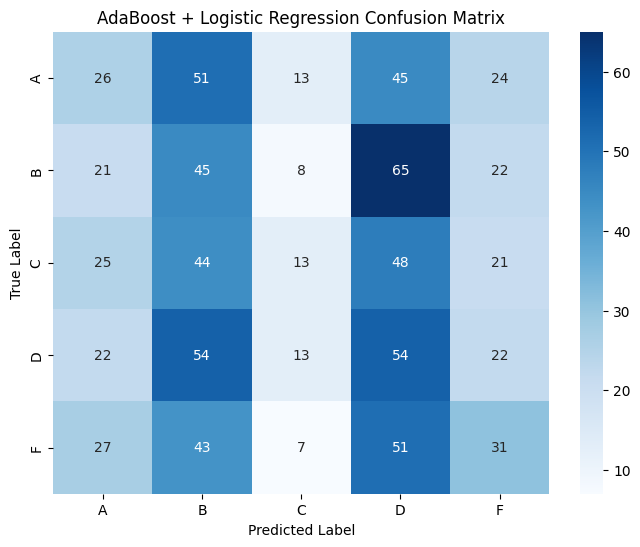

AdaBoost + Logistic Regression Classification Report:
               precision    recall  f1-score   support

           A       0.21      0.16      0.19       159
           B       0.19      0.28      0.23       161
           C       0.24      0.09      0.13       151
           D       0.21      0.33      0.25       165
           F       0.26      0.19      0.22       159

    accuracy                           0.21       795
   macro avg       0.22      0.21      0.20       795
weighted avg       0.22      0.21      0.20       795

AdaBoost + Decision Tree Results:
Accuracy: 0.8528
Precision: 0.8540
Recall: 0.8528
F1 Score: 0.8528


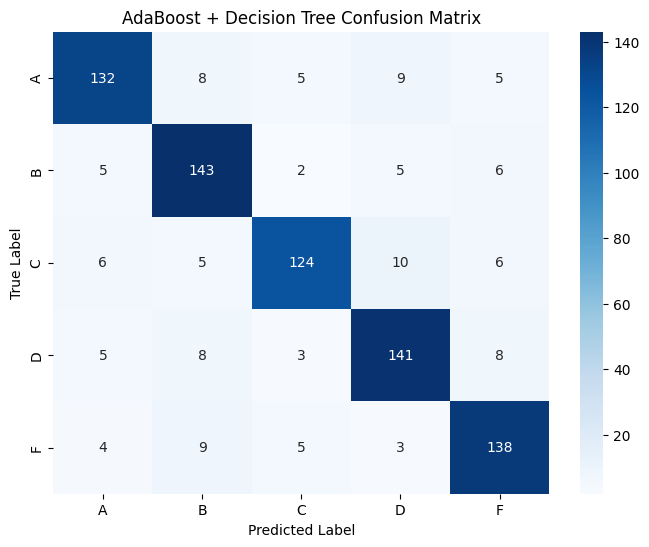

AdaBoost + Decision Tree Classification Report:
               precision    recall  f1-score   support

           A       0.87      0.83      0.85       159
           B       0.83      0.89      0.86       161
           C       0.89      0.82      0.86       151
           D       0.84      0.85      0.85       165
           F       0.85      0.87      0.86       159

    accuracy                           0.85       795
   macro avg       0.85      0.85      0.85       795
weighted avg       0.85      0.85      0.85       795

AdaBoost + SVM Results:
Accuracy: 0.2000
Precision: 0.0400
Recall: 0.2000
F1 Score: 0.0667


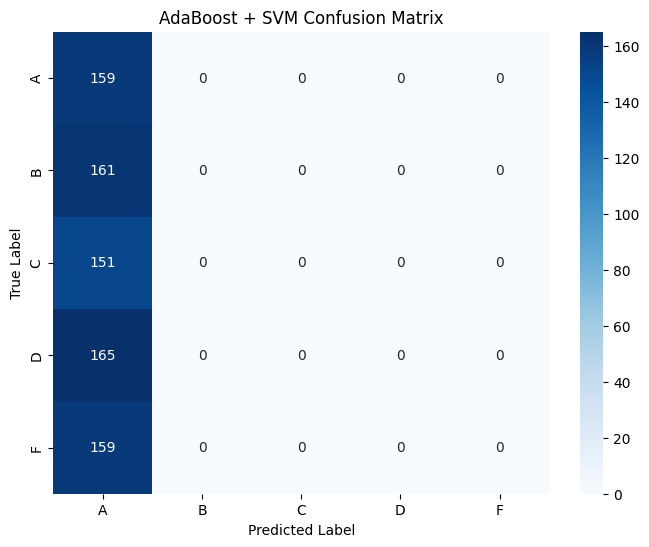

AdaBoost + SVM Classification Report:
               precision    recall  f1-score   support

           A       0.20      1.00      0.33       159
           B       0.00      0.00      0.00       161
           C       0.00      0.00      0.00       151
           D       0.00      0.00      0.00       165
           F       0.00      0.00      0.00       159

    accuracy                           0.20       795
   macro avg       0.04      0.20      0.07       795
weighted avg       0.04      0.20      0.07       795



In [ ]:
!pip install matplotlib seaborn scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_and_visualize(model, X_test, y_test, model_name):
    """
    Evaluates the model and visualizes the results.

    Args:
        model: The trained model.
        X_test: The test features.
        y_test: The test labels.
        model_name: The name of the model (for visualization purposes).
    """
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Evaluate and visualize each model
evaluate_and_visualize(boosted_lr, X_test, y_test, "AdaBoost + Logistic Regression")
evaluate_and_visualize(adaboost, X_test, y_test, "AdaBoost + Decision Tree")
evaluate_and_visualize(boosted_svm, X_test, y_test, "AdaBoost + SVM")

i split my student data keeping the same grade balance in both training and test sets. Then I test three different models: one using logistic regression one using decision trees and one using SVM all boosted with AdaBoost. For each model the function shows how well it did on both the data it learned from and new test data. Finally it makes a bar chart comparing all models side by side so I can easily see which one works best. The chart has all the scores together with a legend explaining what each color means and the bars are tilted a bit so the long model names fit nicely.

                                Train Accuracy  Test Accuracy  \
AdaBoost + Logistic Regression        0.221384       0.212579   
AdaBoost + Decision Tree              0.836478       0.852830   
AdaBoost + SVM                        0.199686       0.200000   

                                Train Precision  Test Precision  Train Recall  \
AdaBoost + Logistic Regression         0.217869        0.221434      0.221384   
AdaBoost + Decision Tree               0.837200        0.854038      0.836478   
AdaBoost + SVM                         0.039874        0.040000      0.199686   

                                Test Recall  Train F1-Score  Test F1-Score  
AdaBoost + Logistic Regression     0.212579        0.205112       0.203844  
AdaBoost + Decision Tree           0.852830        0.836573       0.852805  
AdaBoost + SVM                     0.200000        0.066475       0.066667  


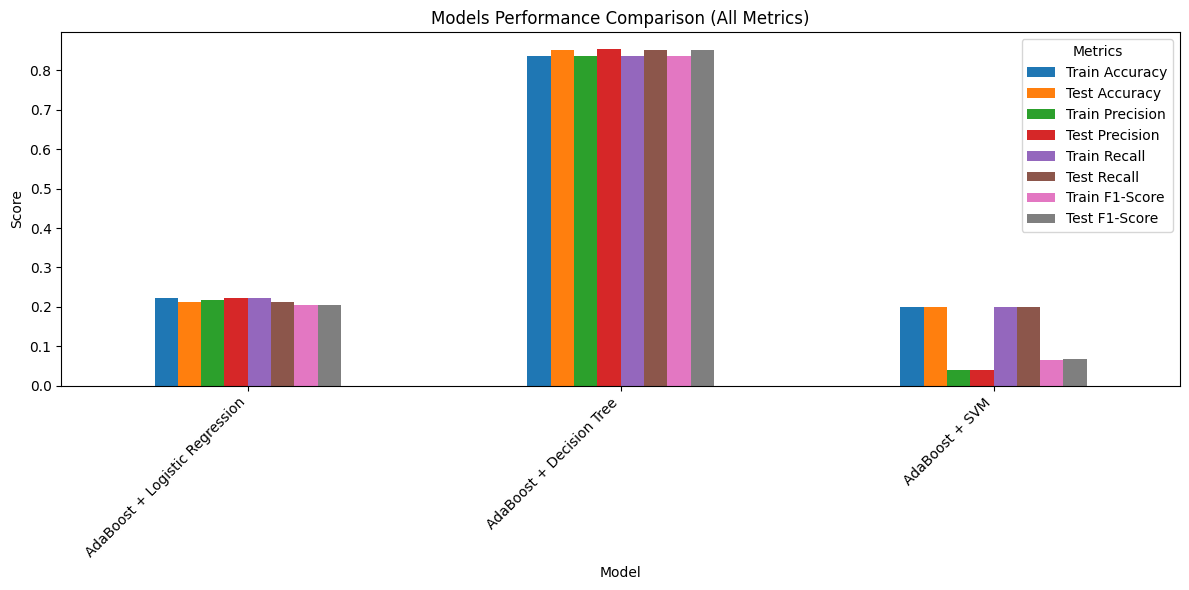

In [ ]:
!pip install matplotlib seaborn scikit-learn openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from openpyxl import load_workbook


def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, model_name, results_df):
    """
    Evaluates the model, visualizes results, and stores metrics in a DataFrame.
    Includes training scores now.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics - Training
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Metrics - Testing
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Store metrics in DataFrame
    results_df.loc[model_name] = [train_accuracy, test_accuracy, train_precision,
                                   test_precision, train_recall, test_recall,
                                   train_f1, test_f1]

# Assuming you have X, y, boosted_lr, adaboost, boosted_svm defined from your previous code

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# DataFrame to store results
results_df = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Train Precision',
                                   'Test Precision', 'Train Recall', 'Test Recall',
                                   'Train F1-Score', 'Test F1-Score'])

# Evaluate models and store results
evaluate_and_visualize(boosted_lr, X_train, y_train, X_test, y_test, "AdaBoost + Logistic Regression", results_df)
evaluate_and_visualize(adaboost, X_train, y_train, X_test, y_test, "AdaBoost + Decision Tree", results_df)
evaluate_and_visualize(boosted_svm, X_train, y_train, X_test, y_test, "AdaBoost + SVM", results_df)

# Display the results DataFrame
print(results_df)



# Visualization: Overall Model Performance
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Models Performance Comparison (All Metrics)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics', loc='upper right')  # Add legend for metrics
plt.tight_layout()
plt.show()

i split my student data keeping the same grade balance in both sets. Then I test three models logistic regression decision tree and SVM all boosted with AdaBoost. The results go in a table showing training and test scores. I also calculate average scores across all models to see overall performance. Finally I make a bar chart of these averages the labels are tilted so they fit better. This helps me quickly compare models and see if they're learning properly or just memorizing.


Overall Scores:
Train Accuracy     0.419182
Test Accuracy      0.421803
Train Precision    0.364981
Test Precision     0.371824
Train Recall       0.419182
Test Recall        0.421803
Train F1-Score     0.369387
Test F1-Score      0.374438
dtype: float64


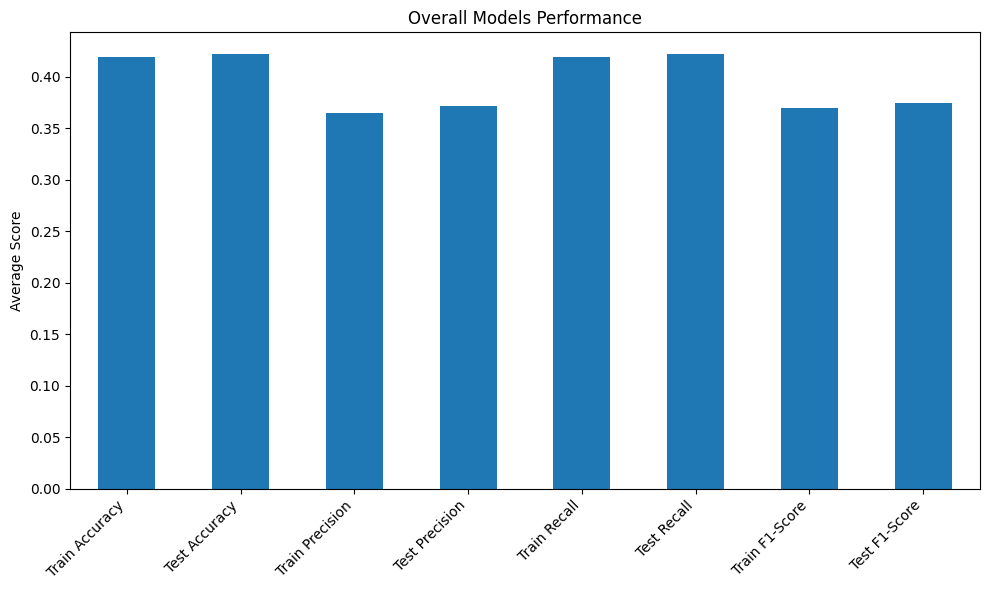

In [ ]:
!pip install matplotlib seaborn scikit-learn openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from openpyxl import load_workbook


def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, model_name, results_df):
    """
    Evaluates the model, visualizes results, and stores metrics in a DataFrame.
    Includes training scores now.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics - Training
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Metrics - Testing
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Store metrics in DataFrame
    results_df.loc[model_name] = [train_accuracy, test_accuracy, train_precision,
                                   test_precision, train_recall, test_recall,
                                   train_f1, test_f1]


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# DataFrame to store results  # <--- Define results_df here
results_df = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Train Precision',
                                   'Test Precision', 'Train Recall', 'Test Recall',
                                   'Train F1-Score', 'Test F1-Score'])

# Evaluate models and store results
evaluate_and_visualize(boosted_lr, X_train, y_train, X_test, y_test, "AdaBoost + Logistic Regression", results_df)
evaluate_and_visualize(adaboost, X_train, y_train, X_test, y_test, "AdaBoost + Decision Tree", results_df)  # Assuming 'adaboost' is defined
evaluate_and_visualize(boosted_svm, X_train, y_train, X_test, y_test, "AdaBoost + SVM", results_df)

# Calculate overall scores
overall_scores = results_df.mean()

# Print overall scores
print("\nOverall Scores:")
print(overall_scores)


# Visualization of overall scores
overall_scores.plot(kind='bar', figsize=(10, 6))
plt.title('Overall Models Performance')
plt.ylabel('Average Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()